In [2]:
from datetime import datetime
# from dateutil.relativedelta import relativedelta
import math
from marketdatalib import map_scrip_to_yfin_ticker, get_nifty_index_data, calculate_beta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from scipy.optimize import minimize

In [48]:
# Number of year of historic data to consider
YEARS_OF_HISTORY = 5

# The risk free return rate. This is often the return on a 10 year government bond.
# At present, the 10 year government bond rate is 6.84%. We are using 7.5% for the sake of simplicity which is the rate of a fixed deposit.
RISK_FREE_RETURN = 0.071
EXPECTED_MARKET_RETURN = 0.18
ACCEPTABLE_VOLATILITY = 0.15


INDIAN_ETFS = ['NIFTY 100', 'NIFTY MIDCAP 150', 'NIFTY 500']
INDIAN_ETFS

['NIFTY 100', 'NIFTY MIDCAP 150', 'NIFTY 500']

In [49]:
master_data = pd.DataFrame()

print(master_data.index)

for ind in INDIAN_ETFS:
    index_data = get_nifty_index_data(index_name=ind, number_of_years=YEARS_OF_HISTORY)['Close']
    index_data = pd.DataFrame(index_data)
    print(index_data.index)
    master_data[ind] = index_data
    # master_data = pd.concat([master_data, index_data], axis=1)

# master_data.columns = INDIAN_ETFS
# master_data = master_data.pct_change()
master_data

RangeIndex(start=0, stop=0, step=1)
DatetimeIndex(['2020-01-06', '2020-01-07', '2020-01-08', '2020-01-09',
               '2020-01-10', '2020-01-13', '2020-01-14', '2020-01-15',
               '2020-01-16', '2020-01-17',
               ...
               '2024-12-20', '2024-12-23', '2024-12-24', '2024-12-26',
               '2024-12-27', '2024-12-30', '2024-12-31', '2025-01-01',
               '2025-01-02', '2025-01-03'],
              dtype='datetime64[ns]', name='Date', length=1257, freq=None)
DatetimeIndex(['2020-01-06', '2020-01-07', '2020-01-08', '2020-01-09',
               '2020-01-10', '2020-01-13', '2020-01-14', '2020-01-15',
               '2020-01-16', '2020-01-17',
               ...
               '2024-12-20', '2024-12-23', '2024-12-24', '2024-12-26',
               '2024-12-27', '2024-12-30', '2024-12-31', '2025-01-01',
               '2025-01-02', '2025-01-03'],
              dtype='datetime64[ns]', name='Date', length=1253, freq=None)


ValueError: cannot reindex on an axis with duplicate labels

In [51]:
n50 = get_nifty_index_data(index_name='NIFTY 50', number_of_years=YEARS_OF_HISTORY)['Close']
n100 = get_nifty_index_data(index_name='NIFTY 100', number_of_years=YEARS_OF_HISTORY)['Close']
n500 = get_nifty_index_data(index_name='NIFTY 500', number_of_years=YEARS_OF_HISTORY)['Close']

n100 = pd.DataFrame(n100)
n100

,Close
Date,
2020-01-06,12090.60
2020-01-07,12154.95
2020-01-08,12131.45
2020-01-09,12319.70
2020-01-10,12359.70
...,...
2024-12-30,24500.75
2024-12-31,24495.55
2025-01-01,24595.70


In [17]:
master_data = pd.concat([master_data, n500], axis=1)
master_data

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [ ]:
master_data[[column for column in master_data.columns if column.endswith('_Return') ]].corr()

,NIFTY 50_Return,NIFTY 100_Return,NIFTY MIDCAP 150_Return,NIFTY SMALLCAP 50_Return,NIFTY ENERGY_Return,NIFTY FINANCIAL SERVICES_Return,NIFTY PRIVATE BANK_Return,NIFTY FMCG_Return,NIFTY200 QUALITY 30_Return,NIFTY AUTO_Return,NIFTY IT_Return,NIFTY PHARMA_Return,NIFTY REALTY_Return,NIFTY METAL_Return,NIFTY 500_Return
NIFTY 50_Return,1.000000,0.758497,0.583741,0.485616,0.455409,0.551085,0.520860,0.405653,0.479840,0.433583,0.343149,0.280288,0.361834,0.375471,0.516806
NIFTY 100_Return,0.758497,1.000000,0.751886,0.616396,0.554905,0.605910,0.568742,0.451671,0.537577,0.482792,0.371479,0.321789,0.410454,0.423507,0.570901
NIFTY MIDCAP 150_Return,0.583741,0.751886,1.000000,0.828540,0.640779,0.582799,0.573538,0.430855,0.582346,0.546182,0.341725,0.373050,0.508829,0.487976,0.593609
NIFTY SMALLCAP 50_Return,0.485616,0.616396,0.828540,1.000000,0.703902,0.566188,0.535113,0.391435,0.531202,0.494231,0.321133,0.336061,0.469392,0.451858,0.537113
NIFTY ENERGY_Return,0.455409,0.554905,0.640779,0.703902,1.000000,0.521882,0.437389,0.373864,0.480787,0.426751,0.262555,0.280377,0.362726,0.426621,0.486541
NIFTY FINANCIAL SERVICES_Return,0.551085,0.605910,0.582799,0.566188,0.521882,1.000000,0.942455,0.552691,0.617418,0.608561,0.382688,0.322093,0.556017,0.511514,0.763409
NIFTY PRIVATE BANK_Return,0.520860,0.568742,0.573538,0.535113,0.437389,0.942455,1.000000,0.538741,0.624837,0.640394,0.380645,0.341050,0.589208,0.541329,0.797294
NIFTY FMCG_Return,0.405653,0.451671,0.430855,0.391435,0.373864,0.552691,0.538741,1.000000,0.758946,0.536206,0.428913,0.480089,0.449024,0.429849,0.660752
NIFTY200 QUALITY 30_Return,0.479840,0.537577,0.582346,0.531202,0.480787,0.617418,0.624837,0.758946,1.000000,0.746966,0.705612,0.579483,0.593565,0.606802,0.827423
NIFTY AUTO_Return,0.433583,0.482792,0.546182,0.494231,0.426751,0.608561,0.640394,0.536206,0.746966,1.000000,0.428270,0.470322,0.625779,0.613438,0.793596


In [ ]:
def expected_return(market_return, risk_free_return, beta, weight = 1):
    return risk_free_return + weight * beta * (market_return - risk_free_return)

Let us assume that NIFTY 500 represents the total market for the sake of brevity. It represnts the universe of stocks that are investable in Indian equity market

In [ ]:
market_returns = master_data['NIFTY 500_Return']

R_m = market_returns.prod() - 1
Sigma_m = market_returns.std()


To start with, let us start with a single security portfolio. The portfolio is constructed with NIFTY 50 and NIFTY PHARMA index.

In [ ]:
portfolio_indices = ['NIFTY 100', 'NIFTY PHARMA']

In [ ]:
returns_matrix = pd.DataFrame(index=portfolio_indices, columns=['Return', 'Beta', 'Volatility', 'ExpectedReturn', 'Sharpe Ratio'])

for index in portfolio_indices:
    index_returns = master_data[index + '_Return'].prod() - 1
    returns_matrix.loc[index, 'Return'] = index_returns
    returns_matrix.loc[index, 'Beta'] = calculate_beta(master_data[index + '_Return'], market_returns)
    returns_matrix.loc[index, 'Volatility'] = master_data[index + '_Return'].std()
    returns_matrix.loc[index, 'ExpectedReturn'] = RISK_FREE_RETURN + returns_matrix.loc[index, 'Beta'] * (R_m - RISK_FREE_RETURN)
    returns_matrix.loc[index, 'Sharpe Ratio'] = (index_returns - RISK_FREE_RETURN) / returns_matrix.loc[index, 'Volatility']

# variannce_i = master_data['NIFTY 100_Return'].var()
# Sigma_i = np.sqrt(variannce_i)
# corr_i_m = master_data['NIFTY 100_Return'].corr(market_returns)
# beta_i = corr_i_m * Sigma_i / Sigma_m
# Sigma_i, beta_i
returns_matrix

,Return,Beta,Volatility,ExpectedReturn,Sharpe Ratio
NIFTY 100,230229365494237972398080.0,0.998121,0.00393,1.51881,58580437999354237681664000.0
NIFTY PHARMA,1.426834,0.620827,0.002447,0.971531,553.978628


In [ ]:
_ = master_data['NIFTY 100_Return']
_.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 36697 entries, 2019-01-15 to 2024-11-01
Series name: NIFTY 100_Return
Non-Null Count  Dtype  
--------------  -----  
36697 non-null  float64
dtypes: float64(1)
memory usage: 573.4 KB


In [ ]:
weights = np.linspace(0, 100, 100)

returns = [expected_return(market_return=R_m, risk_free_return=RISK_FREE_RETURN, beta=beta_i, weight=weight) for weight in weights]
volatilities = [Sigma_i * weight * 100 for weight in weights]


NameError: name 'beta_i' is not defined

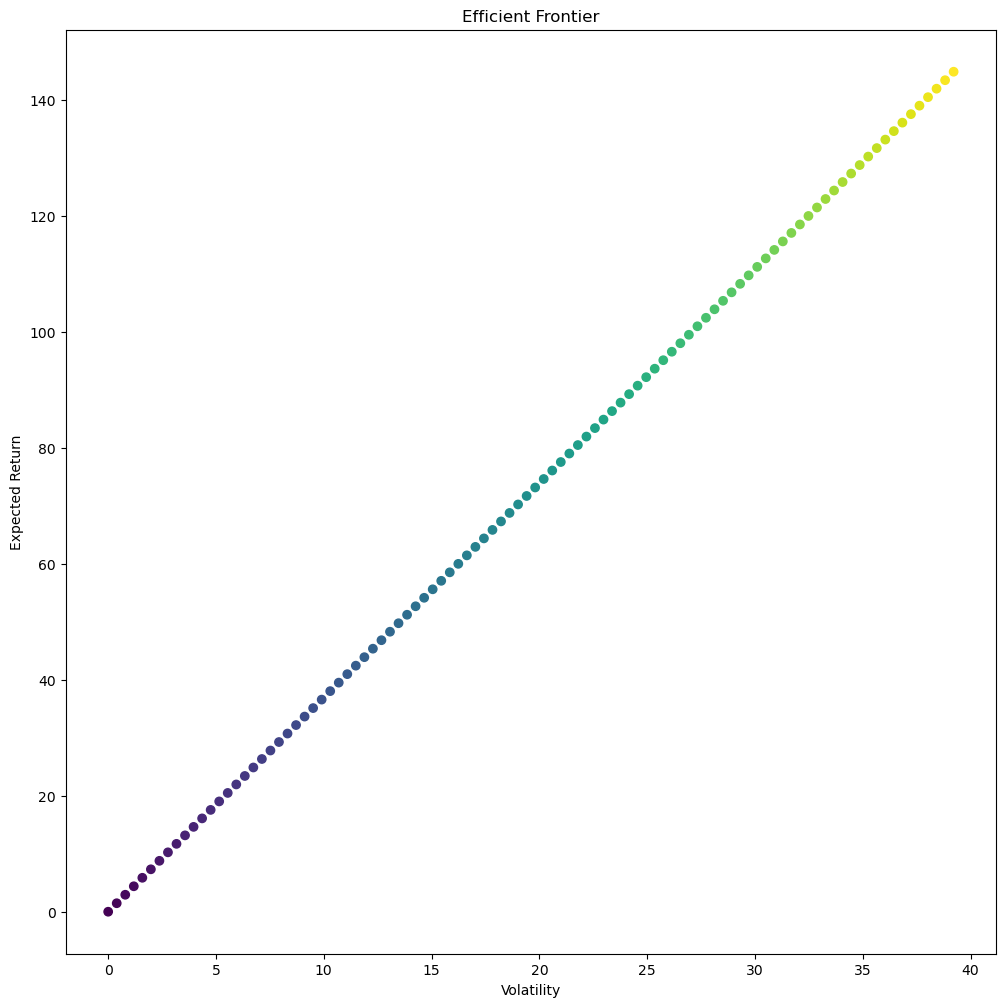

In [ ]:
ax = plt.figure(figsize=(12, 12))

plt.scatter(volatilities, returns, c=volatilities, cmap='viridis')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.show()

In [ ]:
master_data['NIFTY 100_Return'].prod() - 1

-0.9999999587339468

In [ ]:
volatilities

[0.0,
 0.396067271102522,
 0.792134542205044,
 1.188201813307566,
 1.584269084410088,
 1.98033635551261,
 2.376403626615132,
 2.7724708977176538,
 3.168538168820176,
 3.564605439922698,
 3.96067271102522,
 4.356739982127742,
 4.752807253230264,
 5.148874524332785,
 5.5449417954353075,
 5.94100906653783,
 6.337076337640352,
 6.733143608742874,
 7.129210879845396,
 7.525278150947917,
 7.92134542205044,
 8.317412693152962,
 8.713479964255484,
 9.109547235358006,
 9.505614506460528,
 9.901681777563049,
 10.29774904866557,
 10.693816319768093,
 11.089883590870615,
 11.485950861973137,
 11.88201813307566,
 12.278085404178182,
 12.674152675280704,
 13.070219946383224,
 13.466287217485748,
 13.862354488588268,
 14.258421759690792,
 14.654489030793313,
 15.050556301895835,
 15.446623572998359,
 15.84269084410088,
 16.238758115203403,
 16.634825386305923,
 17.030892657408447,
 17.426959928510968,
 17.823027199613488,
 18.219094470716012,
 18.615161741818532,
 19.011229012921056,
 19.407296284023